In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data Gather

We need lots of data to provide a meaningful prior - at a minimum we need:

[ID, epsilon, epsilon_err, numax, numax_err, dnu, dnu_err, BP_RP, BP_RP_err, Teff, Teff_err]

First we need a set of star catalogues to work from.  The obvious red giant catalogue is Yu.  The obvious dwarf (& SG) catalogue is Serenelli.  Where we get the epsilons from is harder.  The the Legacy & Kages stars we can do this easily.   For the SG's we might need to use TWhite's paper but these can probably be improved.

Broadly speaking then, we 

1) Read in Yu

2) Read in Serenelli

3) Concatenate Yu and Serenelli

4) Use the concatenated sample to go and get BP_RP.

5) The select down to a list of stars where we have either epsilon from a published source, or can calculate epsilon from the individual mode frequencies we have already.

6) To calculate our own epsilons, for all peak bagged red giants, Legacy, and Kages, read in the mode frequencies and fit a simple 2nd order asymptotic expansion to get epsilon and its uncertainty.

7) Merge the published epsilon and calculated epsilons (how='inner') back into the the main DataFrame.

8) Save the sample as a csv file to the data dir than cab read in as the Prior sample.

## Step 1 - read in Yu.

Data source: (18/4/19) arXiv - table1.txt & table2.txt

I have edited the files to update the header

In [2]:
df_yu1 = pd.read_csv('Table1.txt', sep='|')
df_yu1.head()

,KICID,kepmag,Length_Quarters,Length_days,numax,numax_err,dnu,dnu_err,amplitude,amplitude_err,fwhm,fwhm_err,maxbg,maxbg_err,Unnamed: 14
0,757137,9.20,17,1308.7,29.99,0.60,3.399,0.011,104.9,4.6,12.3,1.5,2787.2,286.3,NaN
1,892010,11.67,4,206.3,17.85,0.89,2.427,0.078,196.0,20.5,8.5,2.5,17002.1,3464.7,NaN
2,892738,11.73,18,1318.1,7.48,0.35,1.300,0.031,384.4,35.5,3.4,0.7,141955.4,12636.8,NaN
3,892760,13.23,6,380.8,29.48,0.48,3.962,0.116,149.7,8.3,12.0,3.9,6319.1,1108.3,NaN
4,893214,12.58,15,1211.9,41.39,0.54,4.311,0.013,86.1,4.6,15.3,1.6,1337.0,289.9,NaN


In [3]:
df_yu2 = pd.read_csv('Table2.txt', sep='|')
df_yu2.head()

,KICID,Teff,Teff_err,logg,logg_err,FeH,FeH_err,M_noCorrection,err,R_noCorrection,...,M_RGB,err.2,R_RGB,err.3,M_Clump,err.4,R_Clump,err.5,EvoPhase,Unnamed: 20
0,757137,4751,139,2.383,0.012,-0.08,0.30,1.70,0.14,13.91,...,1.55,0.13,13.26,0.39,1.72,0.14,13.97,0.41,1,NaN
1,892010,4834,151,2.161,0.023,0.21,0.30,1.42,0.29,16.37,...,1.36,0.28,16.02,1.34,1.43,0.30,16.47,1.39,0,NaN
2,892738,4534,135,1.769,0.022,-0.25,0.30,1.15,0.21,23.15,...,0.99,0.18,21.49,1.48,1.12,0.20,22.86,1.60,0,NaN
3,892760,5188,183,2.394,0.011,-0.21,0.30,1.00,0.14,10.51,...,1.04,0.15,10.74,0.70,1.00,0.14,10.52,0.68,2,NaN
4,893214,4728,80,2.522,0.008,-0.15,0.15,1.72,0.10,11.90,...,1.54,0.09,11.29,0.24,1.72,0.10,11.92,0.26,1,NaN


In [4]:
df_yu = df_yu1.merge(df_yu2, on='KICID', how='inner')
print(len(df_yu))

16094


Text(0,0.5,'Dnu')

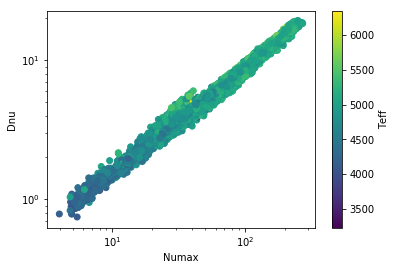

In [5]:
fig, ax = plt.subplots()
cs=ax.scatter(df_yu.numax, df_yu.dnu, c=df_yu.Teff)
ax.set_xscale('log')
ax.set_yscale('log')
cbar = fig.colorbar(cs)
cbar.ax.set_ylabel('Teff')
ax.set_xlabel('Numax')
ax.set_ylabel('Dnu')

## Step 2 - Read in Serenelli

Data source: (18/4/19) arXiv - table3.txt, table4.txt, table5.txt

In the end I wont use table4 for now (the SDSS temps) but with use table5 (the ASCAP temps).


In [6]:
df_aldo1 = pd.read_csv('table3.txt', skiprows=22, sep='\s+')
df_aldo1.head()

,KIC,numax,enumax,Dnu,eDnu,Length,HBR
0,1435467,1382.311,19.038,70.558,0.087,938.1,1.662
1,2010607,674.919,146.523,42.479,2.185,28.9,1.547
2,2309595,643.208,11.226,39.029,0.721,28.9,1.767
3,2450729,1053.105,114.904,61.910,2.539,28.9,1.470
4,2837475,1629.761,18.396,75.720,0.129,1029.4,1.767


In [7]:
df_aldo2 = pd.read_csv('table5.txt', skiprows=42
                       , sep='\s+')
df_aldo2.head()

,KIC,Teff,eTeff,M_H,eM_H,R,eR,ER,seR,M,...,Elogg,selogg,rho,erho,Erho,serho,Age,eAge,EAge,seAge
0,1435467,6096.7,69.276,-0.028,0.099,1.676,0.012,-0.011,0.013,1.277,...,-0.005,0.004,0.27110,0.001138,-0.001015,0.001526,3.746,0.349,-0.324,0.496
1,2010607,6013.5,69.276,-0.070,0.100,2.390,0.104,-0.095,0.028,1.325,...,-0.027,0.006,0.09667,0.009696,-0.009474,0.001512,3.544,0.396,-0.390,0.333
2,2309595,5000.2,69.276,-0.095,0.101,2.300,0.080,-0.073,0.063,1.022,...,-0.008,0.007,0.08390,0.002592,-0.002614,0.001254,9.537,2.667,-2.196,2.517
3,2450729,5840.4,69.276,-0.212,0.100,1.725,0.060,-0.056,0.028,1.047,...,-0.021,0.007,0.20350,0.015640,-0.015730,0.002757,7.724,1.051,-0.953,1.221
4,2837475,6335.4,69.276,-0.015,0.100,1.726,0.065,-0.014,0.067,1.672,...,-0.007,0.020,0.32450,0.002867,-0.002731,0.003638,1.804,0.313,-0.285,0.529


In [8]:
df_aldo = df_aldo1.merge(df_aldo2, how='inner', on='KIC')
print(len(df_aldo))
df_aldo.columns

415


Index(['KIC', 'numax', 'enumax', 'Dnu', 'eDnu', 'Length', 'HBR', 'Teff',
       'eTeff', 'M_H', 'eM_H', 'R', 'eR', 'ER', 'seR', 'M', 'eM', 'EM', 'seM',
       'logg', 'elogg', 'Elogg', 'selogg', 'rho', 'erho', 'Erho', 'serho',
       'Age', 'eAge', 'EAge', 'seAge'],
      dtype='object')

Text(0,0.5,'Dnu')

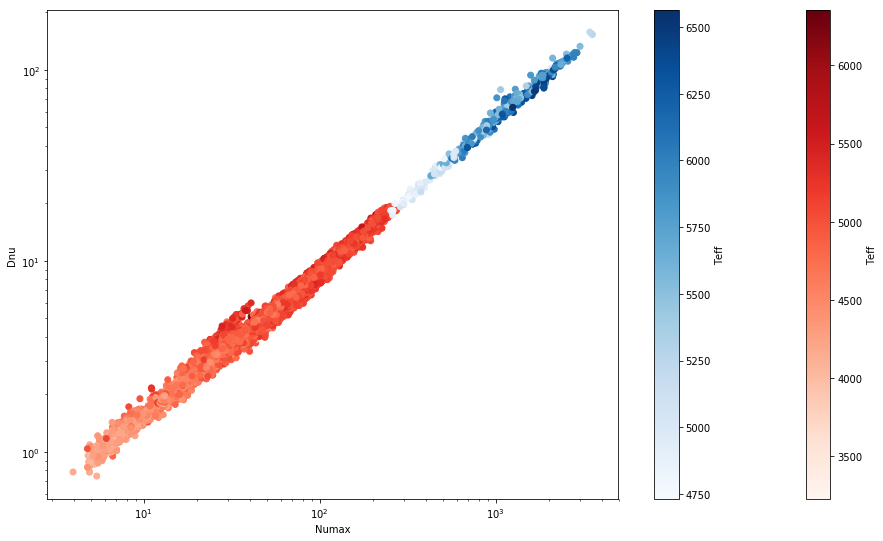

In [9]:
fig, ax = plt.subplots(figsize=[16,9])
cs=ax.scatter(df_yu.numax, df_yu.dnu, c=df_yu.Teff, cmap='Reds')
cs2=ax.scatter(df_aldo.numax, df_aldo.Dnu, c=df_aldo.Teff, cmap='Blues')
ax.set_xscale('log')
ax.set_yscale('log')
cbar = fig.colorbar(cs)
cbar.ax.set_ylabel('Teff')
cbar2 = fig.colorbar(cs2)
cbar2.ax.set_ylabel('Teff')
ax.set_xlabel('Numax')
ax.set_ylabel('Dnu')

## Step 3 - Concat Yu and Serenelli

Take only what you need - MGMT - and the concatenate.

In [10]:
df_yu_ = df_yu[['KICID', 'numax', 'numax_err', 'dnu', 'dnu_err', 'Teff', 'Teff_err', 'EvoPhase']]
df_aldo_ = df_aldo[['KIC', 'numax', 'enumax', 'Dnu', 'eDnu', 'Teff', 'eTeff']]
df_aldo_.rename(columns={'enumax': 'numax_err', 'Dnu': 'dnu', 'eDnu': 'dnu_err', 'eTeff': 'Teff_err'}, inplace=True)
df_yu_.rename(columns={'KICID': 'KIC'}, inplace=True)

/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/frame.py:3027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [11]:
df = pd.concat([df_yu_, df_aldo_])
df.head()

,EvoPhase,KIC,Teff,Teff_err,dnu,dnu_err,numax,numax_err
0,1.0,757137,4751.0,139.0,3.399,0.011,29.99,0.60
1,0.0,892010,4834.0,151.0,2.427,0.078,17.85,0.89
2,0.0,892738,4534.0,135.0,1.300,0.031,7.48,0.35
3,2.0,892760,5188.0,183.0,3.962,0.116,29.48,0.48
4,1.0,893214,4728.0,80.0,4.311,0.013,41.39,0.54


Text(0,0.5,'Dnu')

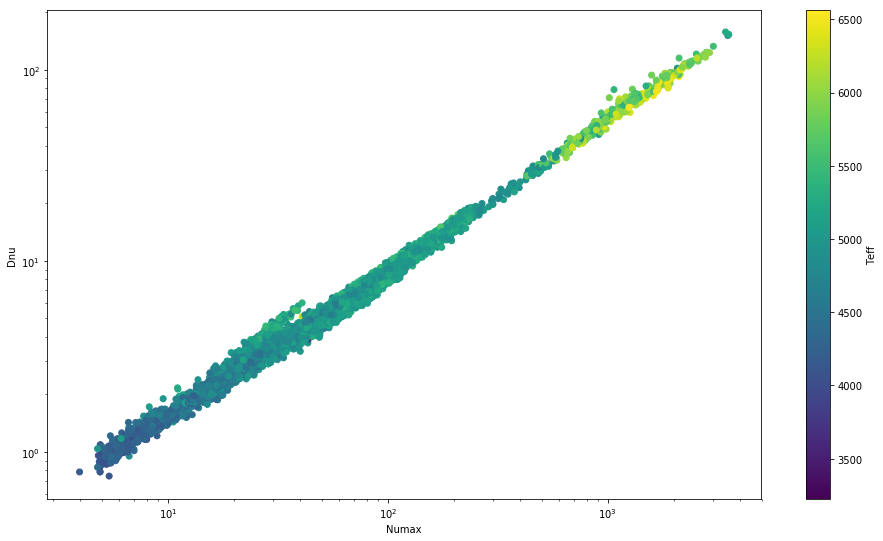

In [12]:
fig, ax = plt.subplots(figsize=[16,9])
cs=ax.scatter(df.numax, df.dnu, c=df.Teff, cmap='viridis')
ax.set_xscale('log')
ax.set_yscale('log')
cbar = fig.colorbar(cs)
cbar.ax.set_ylabel('Teff')
ax.set_xlabel('Numax')
ax.set_ylabel('Dnu')

## Step 4 - Get the *Gaia* BP-RP data
We'll get this from Megan Bedell's Kepler-Gaia crossmatch found here: https://gaia-kepler.fun/

In [13]:
from astropy.table import Table
data = Table.read('kepler_dr2_1arcsec.fits',format='fits')
kdf = data.to_pandas()
print(list(kdf))
kdf = kdf[['kepid', 'bp_rp', 'kepler_gaia_ang_dist']]
kdf.rename(columns={'kepid':'KIC'},inplace=True)

['designation', 'source_id', 'gaia_ref_epoch', 'ra', 'ra_error', 'dec', 'dec_error', 'parallax', 'parallax_error', 'parallax_over_error', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'ra_dec_corr', 'ra_parallax_corr', 'ra_pmra_corr', 'ra_pmdec_corr', 'dec_parallax_corr', 'dec_pmra_corr', 'dec_pmdec_corr', 'parallax_pmra_corr', 'parallax_pmdec_corr', 'pmra_pmdec_corr', 'astrometric_chi2_al', 'astrometric_excess_noise', 'astrometric_excess_noise_sig', 'astrometric_primary_flag', 'duplicated_source', 'phot_g_mean_flux', 'phot_g_mean_flux_error', 'phot_g_mean_mag', 'phot_bp_mean_flux', 'phot_bp_mean_flux_error', 'phot_bp_mean_mag', 'phot_rp_mean_flux', 'phot_rp_mean_flux_error', 'phot_rp_mean_mag', 'bp_rp', 'bp_g', 'g_rp', 'radial_velocity', 'radial_velocity_error', 'phot_variable_flag', 'l', 'b', 'ecl_lon', 'ecl_lat', 'teff_val', 'teff_percentile_lower', 'teff_percentile_upper', 'a_g_val', 'a_g_percentile_lower', 'a_g_percentile_upper', 'e_bp_min_rp_val', 'e_bp_min_rp_percentile_lower', 

In [14]:
def kill_duplicates(df,ID, sep):
    df = df.copy(deep=True)
    sel = df.duplicated(ID, keep=False)
    s = df[sel]
    for idx in range(s[ID].nunique()):
        subset = s[s[ID] == s[ID].values[idx]]
        lock = True  #Iterate and remove the target of largest separation
        while lock:
            if len(subset) > 1.:
                drop = subset[sep].idxmax()
                subset.drop(drop, inplace=True)
                s.drop(drop,inplace=True)
                df.drop(drop, inplace=True)
            elif len(subset == 1.):
                lock = False
            else:
                print('The code shouldnt be here?')
    return df


In [15]:
import numpy as np
bprpdf = pd.merge(df, kdf, on='KIC', how='left')
#bprpdf = kill_duplicates(bprpdf, 'KIC','kepler_gaia_ang_dist')
bprpdf = bprpdf[np.isfinite(bprpdf.bp_rp)]

In [16]:
bprpdf.head()
bprpdf = bprpdf.loc[bprpdf.bp_rp < 2.0]
df = bprpdf

Text(0,0.5,'Dnu')

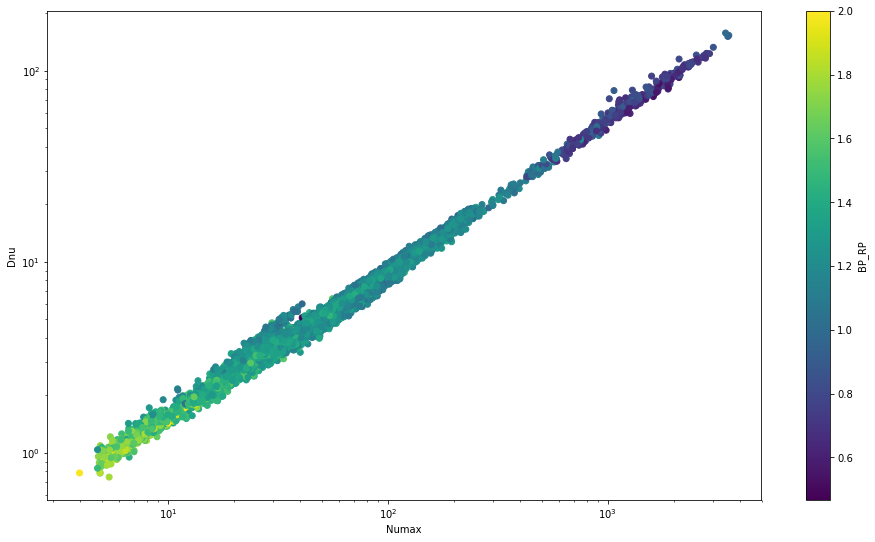

In [17]:
fig, ax = plt.subplots(figsize=[16,9])
cs=ax.scatter(df.numax, df.dnu, c=df.bp_rp, cmap='viridis', vmax=2.0)
ax.set_xscale('log')
ax.set_yscale('log')
cbar = fig.colorbar(cs)
cbar.ax.set_ylabel('BP_RP')
ax.set_xlabel('Numax')
ax.set_ylabel('Dnu')

## Step 5 - Make a list of stars where we can easily get epsilon

We are going to take all the RG stars I have peak bagged, all Legacy and all Kages.  We will add the Tim White sample too.

I actually already have an EpsilonFit repo that has the epsilons for a bunch of stars (1000 Rgs, Legacy, Kages).  I will read in the data from there.

And then I'll add it to the Tim White Data set. (White et al. 2012).   This data set comes from TimW via Warrick (I think that's enough for coauthorship).  There are three files ... 

Gstars_temp_gamma_alt.txt, Fstars_avoid_temp.txt, Fstars_ScAB_teff_gamma_alt_pc.txt

In [27]:
df_g = pd.read_csv('Gstars_temp_gamma_alt.txt', sep='\s+', error_bad_lines=False)
df_favoid = pd.read_csv('Fstars_avoid_temp.txt', sep='\s+', error_bad_lines=False)
df_f = pd.read_csv('Fstars_ScAB_teff_gamma_alt_pc.txt', sep='\s+', error_bad_lines=False)
df_f.rename({'epsA': 'eps', 'epsA_err': 'eps_err'})
df_epsilon = pd.concat([df_g, df_favoid, df_f])
df_epsilon.head()

b'Skipping line 77: expected 15 fields, saw 16\nSkipping line 78: expected 15 fields, saw 16\n'
b'Skipping line 3: expected 21 fields, saw 22\n'


,%,BTEFF,BTEFF_ERR,BTEFF_err,CTEFF,CTEFF_ERR,CTEFF_err,Dnu,Dnu_err,GAMMA_OB,...,dnu_err,eps,epsA,epsA_err,epsB,epsB_err,eps_err,err_lnGamma,lnGamma,lnGamma_err
0,NaN,6264.0,60.0,NaN,6371,161.0,NaN,70.520,0.174,NaN,...,NaN,1.082,NaN,NaN,NaN,NaN,0.046,0.036,1.318,NaN
1,NaN,-9999.0,0.0,NaN,5905,163.0,NaN,61.625,0.128,NaN,...,NaN,1.406,NaN,NaN,NaN,NaN,0.036,0.000,-9999.000,NaN
2,NaN,-9999.0,0.0,NaN,5187,102.0,NaN,18.260,0.068,NaN,...,NaN,1.346,NaN,NaN,NaN,NaN,0.045,0.000,-9999.000,NaN
3,NaN,6040.0,60.0,NaN,6303,140.0,NaN,120.013,0.168,NaN,...,NaN,1.371,NaN,NaN,NaN,NaN,0.030,0.093,0.542,NaN
4,NaN,-9999.0,0.0,NaN,5191,165.0,NaN,24.258,0.048,NaN,...,NaN,1.475,NaN,NaN,NaN,NaN,0.026,0.000,-9999.000,NaN


In [28]:
df_mine = pd.read_csv('my_epsilons.csv')
df_eps = pd.concat([df_mine, df_epsilon])
df_eps = df_eps[['KIC', 'eps', 'eps_err']]
print(len(df_eps))

1433


In [37]:
df_comb = pd.merge(df, df_eps, how='inner', on='KIC')
epm = df_comb.eps
epm[(epm < 0.5)] += 1.0
epm[(epm > 1.5)] -= 1.0
df_comb['eps_mod'] = epm
print(len(df_comb))

1328


/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


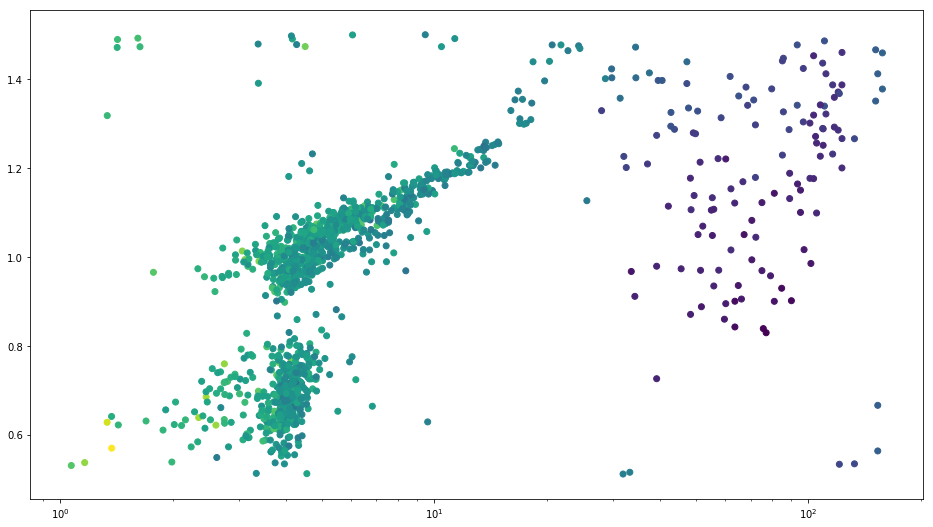

In [41]:
fig, ax = plt.subplots(figsize=[16,9])
ax.scatter(df_comb.dnu, df_comb.eps_mod, c=df_comb.bp_rp)
ax.set_xscale('log')

In [42]:
cols = ['KIC','Teff','Teff_err','dnu','dnu_err','numax','numax_err','bp_rp','eps','eps_err','eps_mod']
df_comb[cols].to_csv('prior_data.csv', index=False)